## Mosaic the image

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from colour_demosaicing import masks_CFA_Bayer

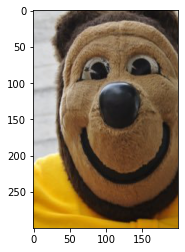

In [2]:
image = imread('image/oski.png', 'png')
shape = (300, 200)
start = (50, 50)
image = image[start[0]:start[0]+shape[0], start[1]:start[1]+shape[1], :] # crop the image
plt.imshow(image)

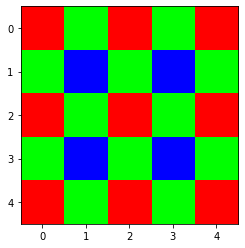

In [3]:
# construct the bayer pattern filter
bayer_filter = np.stack(masks_CFA_Bayer(shape), axis=-1).astype(float)
plt.imshow(bayer_filter[50:55, 50:55, :])

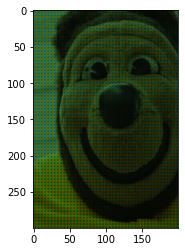

In [4]:
# mosaic the image by applying the Bayer CFA
mosaic_image = image * bayer_filter
plt.imshow(mosaic_image)

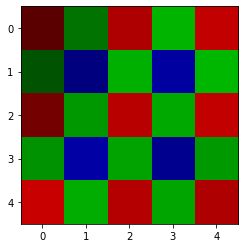

In [5]:
# compared the filtered image and the filter at the same area
plt.imshow(mosaic_image[50:55, 50:55])

**Observation:** There are positions of the mosaic image with zero values in all the channels. 

In [6]:
mosaic_image[299:, 155:160]

array([[[ 0.        ,  0.        ,  0.00392157],
        [ 0.        ,  0.51372552,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.52156866,  0.        ],
        [ 0.        ,  0.        ,  0.01176471]]])

All of the entries in row 3 are zero.

In [7]:
image[299:, 155:160]

array([[[ 0.8039216 ,  0.5176471 ,  0.00392157],
        [ 0.8039216 ,  0.5137255 ,  0.        ],
        [ 0.8117647 ,  0.50980395,  0.        ],
        [ 0.79607844,  0.52156866,  0.00392157],
        [ 0.7921569 ,  0.52156866,  0.01176471]]], dtype=float32)

In [8]:
bayer_filter[299:, 155:160]

array([[[ 0.,  0.,  1.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  1.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  1.]]])

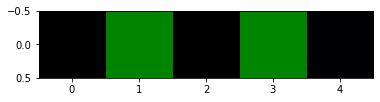

In [9]:
plt.imshow(mosaic_image[299:, 155:160])

## Building the algorithm

### Original

Below is the alternating maximization oracle which is bacially the original alternating minimization orcale with a few changes.

In [27]:
# Alternating maximization oracle
def altmax(r, lpar, p, tol, cmax, gap, c, the_q, Un):
    the = the_q.copy()
    cum_r = np.insert(np.cumsum(r), 0, 0)
    un = Un.shape[0]

    last_cmax = cmax - 1e6
    cnt = 0
    while (True):
        cnt += 1
        for ind in range(p):
            pro = lpar*c.copy()
            for k in range(p):
                if (ind != k):
                    pro = np.multiply(pro, the[cum_r[k] + Un[:,k]]) 

            fpro = np.zeros(r[ind])
            for k in range(un):
                fpro[Un[k,ind]] += pro[k]
            the[cum_r[ind]:cum_r[ind+1]] = (fpro >= 0).astype(int)
            curr_cmax = np.sum(fpro[fpro >= 0])

        if (curr_cmax < last_cmax + tol):
            break
        else:
            last_cmax = curr_cmax

    psi = np.ones(un)
    for k in range(p):
        psi = np.multiply(psi, the[cum_r[k] + Un[:,k]])

    return(psi, the, curr_cmax)

In [28]:
r = image.shape
p = len(r)
lpar = 1
tol = 1e-4
cmax = -float('inf')

# with projection on U
Un = np.argwhere(bayer_filter == 1)
# # without projection on U
# Un = np.arange(np.prod(r)) 
# Un = np.unravel_index(Un, r)
# Un = np.vstack(Un).T

un = len(Un)

mu = []
N_t = 0

# with projection on U
psi_t = np.zeros(un)
# # without projection on U
# psi_t = np.zeros(np.prod(image.shape))

the = np.round(np.random.uniform(0,1,np.sum(r)))

# with projection on U
p_t = mosaic_image.flatten()[bayer_filter.flatten() == 1]
# # without projection on U
# p_t = mosaic_image.flatten()

q_ts = []

cnt = 0

In [29]:
# while (N_t <= lpar):
#     cnt += 1
#     q_t, the_t, _ = altmax(r, lpar, p, tol, cmax, None, p_t, the, Un)
#     mu_t = np.min((p_t / q_t)[q_t > 0])
#     mu.append(mu_t)
#     p_t = p_t - mu_t * q_t
#     psi_t = psi_t + mu_t * q_t
#     N_t = N_t + mu_t
#     print(q_t.sum())
#     if cnt == 20:
#         break

**Observation**: All the entries of the alternating maximization solution, $q_t$, are always 1. I think it is because $c$ which is $p_t$ here is nonnegative, so trivially the solution always has all the entries being 1.

**Observation**: The $\mu$'s are all zeros. I think this is because some entries of $p_t$ are zero, as we saw before, $mu$ has to be zero to satisfy the nonnegativity constraint.

### Solution
Set the entries of $q_t$ where the corresponding $p_t$ is zero to zero. The following is the updated algorithm

In [30]:
r = image.shape
p = len(r)
lpar = 1
tol = 1e-4
cmax = -float('inf')

# with projection on U
Un = np.argwhere(bayer_filter == 1)
# # without projection on U
# Un = np.arange(np.prod(r)) 
# Un = np.unravel_index(Un, r)
# Un = np.vstack(Un).T

un = len(Un)

mu = []
N_t = 0

# with projection on U
psi_t = np.zeros(un)
# # without projection on U
# psi_t = np.zeros(np.prod(image.shape))

# with projection on U
p_t = mosaic_image.flatten()[bayer_filter.flatten() == 1]
# # without projection on U
# p_t = mosaic_image.flatten()

q_ts = []

cnt = 0

In [31]:
while (N_t <= lpar):
    cnt += 1
    the = np.round(np.random.uniform(0,1,np.sum(r)))
    q_t, the_t, _ = altmax(r, lpar, p, tol, cmax, None, p_t, the, Un)
    q_t[p_t == 0] = 0 # CHANGE
    q_ts.append(q_t)
    # the_t[TODO] = 0 
    mu_t = np.min((p_t / q_t)[q_t > 0])
    mu.append(mu_t)
    p_t = p_t - mu_t * q_t
    psi_t = psi_t + mu_t * q_t
    N_t = N_t + mu_t

    if p_t.sum() == 0: # the tensor has been fully decomposed
        break

C:\Users\Wenhao\AppData\Local\Temp\ipykernel_21524\2440312554.py:8: RuntimeWarning: invalid value encountered in true_divide
  mu_t = np.min((p_t / q_t)[q_t > 0])


$\psi_t$ is exactly the same as the demosic image!

In [32]:
np.all((mosaic_image.flatten()[bayer_filter.flatten() == 1] == psi_t))

True

## Modularizing the algorithm

Below I updated the alternating maximization oracle by making it solved only over $\mathcal{C}_1$. Then, we multiply the solution with the `lpar`, $\lambda$.

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from colour_demosaicing import masks_CFA_Bayer


# alternating maximization oracle
# @profile
def altmax(r, p, gamma, tol, cmax, c, the_q, Un):
    the = the_q.copy()
    cum_r = np.insert(np.cumsum(r), 0, 0)
    un = Un.shape[0]

    last_cmax = cmax - 1e6
    cnt = 0
    while (True):
        cnt += 1
        the[cum_r[2]:cum_r[3]] = 0
        the[cum_r[2]+np.random.randint(0, 3)] = 1
        for ind in range(p-1):
            pro = c.copy()
            for k in range(p):
                if (ind != k):
                    #pro = np.multiply(pro, the[cum_r[k] + Un[:,k]])
                    mask = (the[cum_r[k] + Un[:,k]] == 0)
                    pro[mask] = 0 

            fpro = np.zeros(r[ind])
            # # Original
            # for k in range(un):
            #     fpro[Un[k,ind]] += pro[k]

            # # Speed up 1
            # for k in np.argwhere(pro != 0):
            #     fpro[Un[k,ind]] += pro[k]
            
            # # Speed up 2
            # for i in range(r[ind]):
            #     fpro[i] += pro[np.argwhere(Un[:, ind] == i)].sum()

            # Speed up 3
            for i in range(r[ind]):
                if ind == 0:
                    idx = np.arange(i*600, (i+1)*600)
                    fpro[i] += pro[idx].sum()
                elif ind == 1:
                    idx = np.repeat(np.arange(0, 300) * 600, 3) + np.tile(np.arange(i*3, (i+1)*3), 300)
                    fpro[i] += pro[idx].sum()
                else:
                    idx = np.arange(60000) * 3 + i
                    fpro[i] += pro[idx].sum()

            mask = (fpro >= np.sort(fpro)[r[ind] - gamma[ind]])
            #if ind < 2:
            #    mask = (fpro >= np.sort(fpro)[r[ind] - mu[ind]])
            #else:
            #    mask = np.full(r[ind], True)
            the[cum_r[ind]:cum_r[ind+1]] = (mask).astype(int)
            curr_cmax = np.sum(fpro[mask])

        if (curr_cmax < last_cmax + tol):
            break
        else:
            last_cmax = curr_cmax

    psi = np.ones(un)
    for k in range(p):
        psi = np.multiply(psi, the[cum_r[k] + Un[:,k]])

    return(psi, the, curr_cmax)

# @profile    
def heuristic_1(p_0, filter, gamma, proj=False, lpar=1, tol=1e-4):
    """
    Deflate/decompose the tensor p_0 of the mosaic image
    ---
    Arguments:
    p_0 (np.array): the mosaic image
    filter (np.array): the filter used to mosaic the image
    gamma (list[scalar]): the l1 norm upper constraint on every theta
    proj (bool): working in proj_U(C_lpar) if True
    lpar (scalar): the lambda parameter
    tol (scalar): the tolarance used in the alternating maximization

    Returns:
    psi_t (np.array): the flatten version
    Psi_t (np.array): the original version
    mu (list[scalar]): a list of mu_t
    q (list[np.array]): a list of q_t
    """

    # initializing parameters
    r = p_0.shape
    p = len(r)
    cmax = -float('inf')
    if proj:
        Un = np.argwhere(filter == 1)      
        p_t = p_0.flatten()[bayer_filter.flatten() == 1]
    else:
        Un = np.arange(np.prod(r)) 
        Un = np.unravel_index(Un, r)
        Un = np.vstack(Un).T
        p_t = mosaic_image.flatten()
    un = len(Un)
    N_t = 0
    psi_t = np.zeros(un)
    mu = []
    q = []

    # the deflation algorithm
    while (N_t <= lpar):
        print(N_t)
        the = np.round(np.random.uniform(0,1,np.sum(r)))
        q_t, _, _ = altmax(r, p, gamma, 0.01, cmax, p_t, the, Un)
        q.append(q_t)
        mu_t = np.min((p_t / q_t)[(p_t > 0) & (q_t > 0)])
        mu.append(mu_t)
        p_t = p_t - mu_t * q_t
        psi_t = psi_t + mu_t * q_t
        N_t = N_t + mu_t

        if p_t.sum() == 0: # the tensor has been fully decomposed
            break
    
    # recover the original shape
    if proj:
        Psi_t = np.zeros(image.shape)
        np.put(Psi_t, np.ravel_multi_index(Un.T.tolist(), image.shape), psi_t)
    else:
        Psi_t = psi_t.reshape(r)

    return psi_t, Psi_t, mu, q
        

## Experiment

$\lambda = 1$

0
0.784313738346
1.58823531866
1.59215688752
2.44313728856


C:\Users\Wenhao\AppData\Local\Temp\ipykernel_6688\1833855423.py:116: RuntimeWarning: divide by zero encountered in true_divide
  mu_t = np.min((p_t / q_t)[(p_t > 0) & (q_t > 0)])
C:\Users\Wenhao\AppData\Local\Temp\ipykernel_6688\1833855423.py:116: RuntimeWarning: invalid value encountered in true_divide
  mu_t = np.min((p_t / q_t)[(p_t > 0) & (q_t > 0)])


3.21176475333
4.02352947043
4.84313732432
5.65882360935
6.4431373477
7.21568638086
8.03529423475
8.85098052025
9.61960798502
9.62352955388
10.3764707451
11.1490197782
11.9764707689
12.7372550969
13.529411972
14.3450982575
15.0156865125
15.8352943663
16.5882355575
17.3764708643
18.1764708762
18.9176473622
19.6392160063
19.6431375747
20.2862748508
21.0117650633
21.0117650637
21.6901964555
22.447059215
22.4745101924
22.4901964646
23.1647062879
23.1686278568
23.9294121847
24.5647063241
25.1803926216
25.9176475392
26.4352946267
27.1098044501
27.1137260166
27.5921573904
28.2470593718
28.2470593727
28.541177032
29.1176476455
29.1411770564
29.1647064677
29.8666672697
30.2666672757
30.3725496223
30.4627456954
30.5568633368
30.5843143156
31.3647064855
31.384314328
32.1568633611
32.16078493
32.6431379043
32.7450986826
32.7450986835
32.8274516198
32.8431378934
32.9960790607
33.058824155
33.3137261304
33.509804565
33.6117653432
33.7725496474
33.7882359209
34.529412407
34.5294124074
34.6901967116
34

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


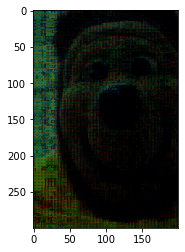

In [54]:
shape = (300, 200)
start = (50, 50)
image = imread('image/oski.png', 'png')   
image = image[start[0]:start[0]+shape[0], start[1]:start[1]+shape[1], :]

bayer_filter = np.stack(masks_CFA_Bayer(shape), axis=-1).astype(float)
mosaic_image = image * bayer_filter

psi_t_unproj, Psi_t_unproj, mu_unproj, q_unproj = heuristic_1(mosaic_image, bayer_filter, [12, 8, 1], proj=False, lpar=100)

fig, ax = plt.subplots()
ax.imshow(Psi_t_unproj)
fig.savefig('recover.png')

0
0.639215707779
1.6274510026
2.45490199327
3.32156866789
4.18039220572


C:\Users\Wenhao\AppData\Local\Temp\ipykernel_6688\1743902627.py:110: RuntimeWarning: divide by zero encountered in true_divide
  mu_t = np.min((p_t / q_t)[(p_t > 0) & (q_t > 0)])
C:\Users\Wenhao\AppData\Local\Temp\ipykernel_6688\1743902627.py:110: RuntimeWarning: invalid value encountered in true_divide
  mu_t = np.min((p_t / q_t)[(p_t > 0) & (q_t > 0)])


4.80392163992
5.65098047256
6.505882442
7.1333334446
8.01568639278
8.85882365704
9.68235307932
10.5882354379
11.4823530912
12.3372550607
13.2000001669
14.0745099783
14.9490197897
15.7686276436
16.6705884337
17.5294119716
18.384313941
19.2039217949
20.0549021959
20.9176473022
21.7725492716
22.5843139887
23.4274512529
24.258823812
24.890196383
25.741176784
26.5568630695
27.3647062182
28.003921926
28.8627454638
29.7137258649
30.5686278343
31.3921572566
32.2392160892
32.8666670918
33.6784318089
34.6666671038
35.5137259364
36.4941180944
37.3490200639
38.2941181064
39.2745102644
40.1254906654
40.9254906774
41.5490201116
42.403922081
43.294118166
44.1333338618
44.7803927064
45.3333339095
46.168628037
46.9411770701
47.7882359028
48.7725496292
49.6235300303
50.4980398417
51.4431378841
52.3647065163
53.3333339691
54.1843143702
55.1137261391
55.9725496769
56.8156869411
57.7882359624
58.7568634152
59.7137261629
60.5607849956
61.1725497246
62.1058830619
63.0235301256
63.8627458215
64.7137262225
65.

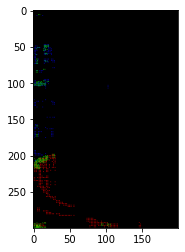

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from colour_demosaicing import masks_CFA_Bayer
np.random.seed(10)

shape = (300, 200)
start = (50, 50)
image = imread('image/oski.png', 'png')   
image = image[start[0]:start[0]+shape[0], start[1]:start[1]+shape[1], :]

bayer_filter = np.stack(masks_CFA_Bayer(shape), axis=-1).astype(float)
mosaic_image = image * bayer_filter

psi_t_unproj, Psi_t_unproj, mu_unproj, q_unproj = heuristic(mosaic_image, bayer_filter, [3, 2, 1], proj=False, lpar=100)

fig, ax = plt.subplots()
ax.imshow(Psi_t_unproj)
fig.savefig('recover.png')

In [25]:
a = np.zeros(3)
index = np.array([0, 1, 0, 2, 1, 1])
value = np.array([1, 1, 1, 1, 1, 1])

a[index] += value

print('Expect:', np.array([2, 3, 1]))
print('Actual:', a)

Expect: [2 3 1]
Actual: [ 1.  1.  1.]


In [13]:
np.repeat(np.arange(0, 300) * 600, 3) + np.tile((0, 1, 2), 300)

array([     0,      1,      2,    600,    601,    602,   1200,   1201,
         1202,   1800,   1801,   1802,   2400,   2401,   2402,   3000,
         3001,   3002,   3600,   3601,   3602,   4200,   4201,   4202,
         4800,   4801,   4802,   5400,   5401,   5402,   6000,   6001,
         6002,   6600,   6601,   6602,   7200,   7201,   7202,   7800,
         7801,   7802,   8400,   8401,   8402,   9000,   9001,   9002,
         9600,   9601,   9602,  10200,  10201,  10202,  10800,  10801,
        10802,  11400,  11401,  11402,  12000,  12001,  12002,  12600,
        12601,  12602,  13200,  13201,  13202,  13800,  13801,  13802,
        14400,  14401,  14402,  15000,  15001,  15002,  15600,  15601,
        15602,  16200,  16201,  16202,  16800,  16801,  16802,  17400,
        17401,  17402,  18000,  18001,  18002,  18600,  18601,  18602,
        19200,  19201,  19202,  19800,  19801,  19802,  20400,  20401,
        20402,  21000,  21001,  21002,  21600,  21601,  21602,  22200,
      

## The second heuristic

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from colour_demosaicing import masks_CFA_Bayer

def place_block(rows, cols, c, p_t, block_size):
    if not isinstance(block_size, np.ndarray):
        block_size = np.array(block_size)
        
    region = p_t[..., c].copy() # c-th channel
    region[region <= 0] = np.inf
    region = region[rows[0]:rows[1], cols[0]:cols[1]]
    
    mu_t_idx = np.unravel_index(np.argmin(region), region.shape)
    mu_t = region[mu_t_idx]

    if np.isinf(mu_t):
        mu_t = 0

    mu_t_idx = (mu_t_idx[0] + rows[0], mu_t_idx[1] + cols[0], c)

    left = block_size // 2
    right = block_size - left
    q_t = np.zeros(p_t.shape)
    q_t[mu_t_idx[0] - left[0]: mu_t_idx[0] + right[0], mu_t_idx[1] - left[1]: mu_t_idx[1] + right[1], c] = 1

    return q_t, mu_t, mu_t_idx

# ### Testing Cases ###
# np.random.seed(10)
# mask = np.random.randint(low=0, high=2, size=(5, 5, 3))
# a = mask * np.random.rand(5, 5, 3)

# def test_place_block_1():
#     _, mu_t, mu_t_idx = place_block((0, 3), (0, 3), 0, a, [3, 2])
#     assert np.isclose(mu_t, 0.1146488)
#     assert mu_t_idx == (2, 2, 0)

# def test_place_block_2():
#     _, mu_t, mu_t_idx = place_block((2, 5), (1, 3), 0, a, [3, 2])
#     assert np.isclose(mu_t, 0.09285611)
#     assert mu_t_idx == (4, 1, 0)

# def test_place_block_3():
#     _, mu_t, mu_t_idx = place_block((2, 3), (2, 3), 1, a, [3, 2])
#     assert np.isclose(mu_t, 0)
#     assert mu_t_idx == (2, 2, 1)

# def test_place_block_4():
#     _, mu_t, mu_t_idx = place_block((2, 3), (3, 4), 1, a, [3, 2])
#     assert np.isclose(mu_t, 0.52381088)
#     assert mu_t_idx == (2, 3, 1)

# def test_place_block_5():
#     _, mu_t, mu_t_idx = place_block((0, 5), (0, 5), 2, a, [3, 2])
#     assert np.isclose(mu_t, 0.02917956)
#     assert mu_t_idx == (4, 4, 2)

# test_place_block_1()
# test_place_block_2()
# test_place_block_3()
# test_place_block_4()
# test_place_block_5()

In [14]:
def build_channel(p_0, block_size, c, lpar):
    r = p_0.shape
    P_t = p_0
    N_t = 0
    Psi_t = np.zeros(r)
    mu = []
    q = []

    row_boundary = [0, r[0]]
    col_boundary = [0, r[1]]

    while True:
        num_boundary = len(row_boundary)
        for i in range(num_boundary-1):
            for j in range(num_boundary-1):
                # print((row_boundary[i], row_boundary[i+1]), (col_boundary[j], col_boundary[j+1]))
                if (row_boundary[i+1] - row_boundary[i]) * (col_boundary[j+1] - col_boundary[j]) <= 10:
                    return Psi_t, mu, q
                
                q_t, mu_t, mu_t_idx = place_block((row_boundary[i], row_boundary[i+1]), (col_boundary[j], col_boundary[j+1]), c, P_t, block_size)

                if N_t + mu_t > lpar:
                    return Psi_t, mu, q
                else:
                    N_t = N_t + mu_t
                    Psi_t = Psi_t + mu_t * q_t
                    P_t = P_t - mu_t * q_t
                    mu.append(mu_t)
                    q.append(q_t)      
        
        for k in range(1, num_boundary):
            row_boundary.append(row_boundary[k-1] + (row_boundary[k] - row_boundary[k-1]) // 2)
            col_boundary.append(col_boundary[k-1] + (col_boundary[k] - col_boundary[k-1]) // 2)
        
        row_boundary.sort()
        col_boundary.sort()
    

In [15]:
def heuristic_2(p_0, block_size, lpars):
    Psi = np.zeros(p_0.shape)
    mu = []
    q = []

    for c in range(3):
        Psi_c, mu_c, q_c = build_channel(p_0, block_size, c, lpars[c])
        Psi = Psi + Psi_c
        mu.extend(mu_c)
        q.extend(q_c)
    
    return Psi, mu, q

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


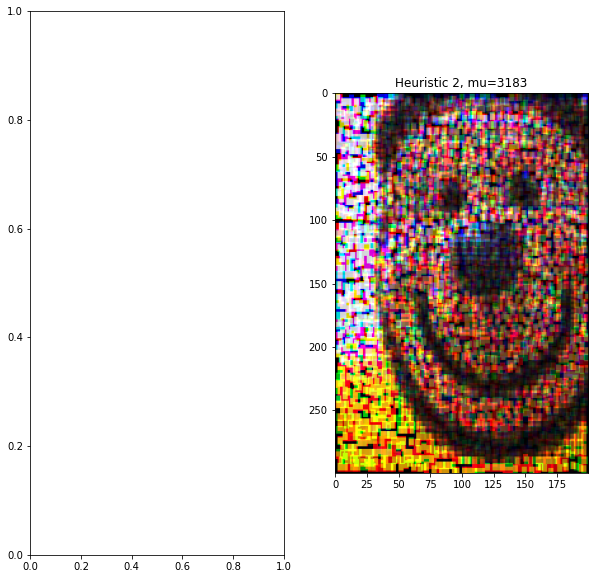

In [16]:
shape = (300, 200)
start = (50, 50)
image = imread('image/oski.png', 'png')   
image = image[start[0]:start[0]+shape[0], start[1]:start[1]+shape[1], :]

bayer_filter = np.stack(masks_CFA_Bayer(shape), axis=-1).astype(float)
mosaic_image = image * bayer_filter

lpar = 5000
_, Psi_1, mu_1, q_1 = heuristic_1(mosaic_image, bayer_filter, [6, 4, 1], proj=False, lpar=lpar)
Psi_2, mu_2, q_2 = heuristic_2(mosaic_image, [6, 4], [lpar/3, lpar/3, lpar/3])

fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(Psi_1)
axes[1].imshow(Psi_2)
axes[0].set_title('Heuristic 1')
axes[1].set_title(f'Heuristic 2, mu={round(sum(mu_2))}')
fig.savefig('recover.png')

In [18]:
Psi_2

array([[[ 0.        ,  0.82745099,  0.        ],
        [ 0.        ,  0.82745099,  0.        ],
        [ 0.        ,  0.82745099,  0.        ],
        ..., 
        [ 0.        ,  0.        ,  0.64313728],
        [ 0.        ,  0.        ,  0.64313728],
        [ 0.        ,  0.        ,  0.        ]],

       [[ 0.82745099,  0.82745099,  0.        ],
        [ 0.82745099,  0.83137256,  0.        ],
        [ 1.65490198,  0.83137256,  0.        ],
        ..., 
        [ 0.        ,  0.        ,  0.64313728],
        [ 0.        ,  0.        ,  0.64313728],
        [ 0.        ,  0.        ,  0.        ]],

       [[ 0.82745099,  0.82745099,  0.        ],
        [ 0.82745099,  0.83137256,  0.84313726],
        [ 1.65490198,  0.83137256,  0.84313726],
        ..., 
        [ 0.        ,  0.        ,  0.64313728],
        [ 0.        ,  0.        ,  0.64313728],
        [ 0.        ,  0.        ,  0.        ]],

       ..., 
       [[ 0.        ,  0.        ,  0.        ],
        